# Model Explainability for the Wonderlic AI-Powered Job Analysis

This notebook shows how we extracted the most important features for our job analysis models and provides an example of how we determined which features were most important for making a specific prediction for a single job description.

## Imports

In [1]:
import lime
import lime.lime_tabular
import pickle
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import plot_importance
import matplotlib as pyplot
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline  

## Variables

In [2]:
# Path location of the KSA model you would like to explain
MODEL_PATH = 'model_k_Medicine_and_Dentistry.pkl'

# Path location of the data used to train your model
DATA_PATH = 'test_all.pkl'

# Path location of the processed text that you want to generate an explainable prediction for
PROCESSED_TEXT_PATH = 'registered_nurse_jd_all_feats_df.pkl'

## Load Model and Data

In [3]:
with open(MODEL_PATH, 'rb') as handle:
    model = pickle.load(handle)
        
with open(DATA_PATH, 'rb') as handle:
    data = pickle.load(handle)
    
feature_list = list(data)[:len(model.feature_importances_)]

## Overall Model Explainability

First we will look at which features are most important overall for the KSA model of Medicine and Dentistry.

In [4]:
# This function pulls out the most important features from the XGBoost model and lists them for us in an 
# easy to read DataFrame (to return the entire DataFrame, set `num_top_features = 0`)

def get_model_explained_df(model, feature_list, num_top_features = 0):
    importance = pd.DataFrame.from_dict({
        'feature_name': feature_list,
        'feature_importance': model.feature_importances_})
    
    if num_top_features == 0:
        return importance.sort_values('feature_importance', ascending = False)
    else:
        return importance.sort_values('feature_importance', ascending = False).head(num_top_features)


model_explained_df = get_model_explained_df(model, feature_list, 15)
model_explained_df

,feature_name,feature_importance
4,4_lda,0.259871
6495,healthcare,0.085237
9364,patient,0.015775
206,empath_technology,0.012972
11045,sale,0.012530
8893,nurse,0.012448
88,empath_journalism,0.011973
11944,strategy,0.011680
1962,analyst,0.011057
1,1_lda,0.010506


Using the built-in XGBoost plotting function, we can see these feature importances in a bar graph

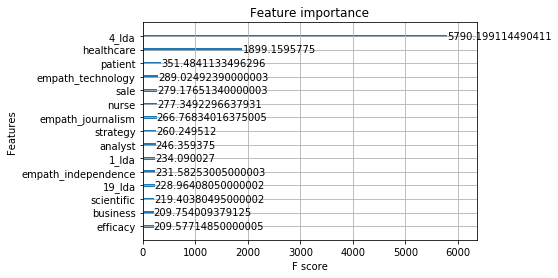

In [5]:
plot_importance(model, max_num_features = 15, importance_type = 'gain')

## Local Interpretability

Next, we will walk through how we identified the most important features for predicting our registered nurse job description required the Medical and Dentistry KSA.

LIME can't handle DataFrames, but our XGBoost model requires DataFrames with column names. This class is a wrapper that fixes that.

In [6]:
class ModifiedModel:
    def __init__(self, model, feature_names):
        self.model = model
        self.feature_names = list(feature_names)
        
    def predict_proba(self, X):
        X = pd.DataFrame(X, columns = self.feature_names)
        return self.model.predict_proba(X) 

We need to load the processed text from our job description which is made up of all the TF-IDF, LDA, and Empath values for that job description.  These are the same extracted values for the features that would be passed into each KSA model to determine if that KSA is required or not for the job description.

In [7]:
with open(PROCESSED_TEXT_PATH, 'rb') as handle:
    processed_text = pickle.load(handle)

Below, we want to show you what `processed_text` actually looks like so you have a better idea of the values we have extracted from the registered nurse job description so you can see what values we are passing to LIME for local interpretability.

In [8]:
processed_text

,0_lda,1_lda,2_lda,3_lda,4_lda,5_lda,6_lda,7_lda,8_lda,9_lda,...,zealand,zero,zh2zyknekz7plvz0,zimmermann,zinc,zip,zoho,zone,zoom,zuniga
0,0.0,0.0,0.0,0.0,0.42618,0.0,0.055296,0.058806,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next we can modify our model for LIME, convert our dataset DataFrame into values for LIME, build a LIME explainer, and then have LIME create a simple linear regression model to identify the 15 features that would make the Medicine and Dentistry KSA more or less likely to be identified within our job description.

In [9]:
mod_model = ModifiedModel(model, feature_list)
train = data.iloc[:, :len(model.feature_importances_)].values
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names = feature_list, 
                                                   class_names = ['No', 'Yes'], 
                                                   discretize_continuous = True)
exp = explainer.explain_instance(processed_text.values[0], mod_model.predict_proba, num_features = 15)
exp

With the LIME explainer regression model completed, we can examine a list of the 15 features and their weights as well as a graphical depiction of which features are moving our model in the "Yes" or "No" direction.

In [10]:
exp.as_list()

[('221 <= 0.00', -0.22827795678695695),
 ('fulltime > 0.00', 0.21458990335944964),
 ('ranked <= 0.00', -0.12942358522737837),
 ('adient <= 0.00', -0.1293515642555501),
 ('readability <= 0.00', -0.11639139364693857),
 ('tribal <= 0.00', -0.08735683275905176),
 ('governing <= 0.00', -0.07684884278468654),
 ('nurse > 0.00', 0.0585309686370613),
 ('intense <= 0.00', -0.0457408995312109),
 ('ims <= 0.00', -0.044443295583947946),
 ('southeast <= 0.00', -0.0374251054014655),
 ('patient > 0.00', 0.03578727010616305),
 ('4_lda > 0.01', 0.031297629197910404),
 ('postage <= 0.00', -0.030784325431412202),
 ('cutting <= 0.00', -0.01999467801660313)]

In [12]:
#exp.show_in_notebook()
# Remove the below line when using this notebook for your own use
Image(url= "https://i.imgur.com/qq1CCJA.png")

With that, we can see the model predicts a 97% probability that the Medicine and Dentistry KSA would be required within our registered nurse job description.  We can also see that the features 4_lda, nurse, patient, and fulltime have the most important impact on determining that the Medicine and Dentistry KSA is required in this job description.  For example, the job description scores a standardized probability of 0.43 for the 4_lda topic being present, which, combined with the 4_lda topic having a regression beta weight of 0.03, partially explains why the Medicine and Dentistry KSA was pushed in the "Yes" direction for being required for our job description.